In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations

In [ ]:
Stage=2
folder_name='experiment and result stage'+str(Stage)
Dataset="Mnist" #if baseline then Basline .../...
baseline=None #None or 11 33 55
if baseline:
  Dataset=Dataset+"/"+baseline
filename="Copy of " + Dataset + "_result.csv"
methods=['deeplift', 'integrated_gradients']
method='deeplift'
flops_dict = {"conv1x1FLOPS": 0.012544, "conv1x1_3x3FLOPS": 0.909, "conv1x1_5x5FLOPS": 2.515, "totalFLOPS": 13.274}
#branch_baseline_flop=0
#flops_dict = {"branch1": branch_baseline_flop, "branch2": branch_baseline_flop, "branch3": branch_baseline_flop, "totalFLOPS": 0}
end_epoch=0

In [ ]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed_data/'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist/Copy of Mnist_result.csv


In [ ]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [ ]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    if not baseline:
      df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
      df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)
    else:
      df.rename(columns={'branch1.1': 'branch1', 'branch2.1': 'branch2', 'branch3.1': 'branch3'}, inplace=True)
      df.drop(columns=['branch1.0', 'branch2.0', 'branch3.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [ ]:
def normalize_feature_attribution(df, threshold=70):
    # Columns to be normalized
    if not baseline:
      layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']
    else:
      layers=[['branch1.0','branch2.0','branch3.0']]

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    if not baseline:
      df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)
    else:
      df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

get standard deviation for each layer's feature attribution

In [ ]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [ ]:
FA_SD.to_csv(save_folder+"/"+method+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" all_FA_SD.csv")

In [ ]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,std_norm_conv1x1,std_norm_conv1x1_3x3,std_norm_conv1x1_5x5,avg_std,train accuracy epoch0,test accuracy epoch0,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.192640,0.272455,0.534904,0.042882,0.156341,0.169519,0.122914,92.026444,93.465333,0.012544,0.909,2.515,13.274
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.178649,0.302862,0.518489,0.031016,0.151539,0.162346,0.114967,90.999444,93.716000,0.012544,0.909,2.515,13.274
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.208813,0.302602,0.488585,0.038093,0.133041,0.152096,0.107743,89.626889,93.467333,0.012544,0.909,2.515,13.274
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.179482,0.275672,0.544846,0.035383,0.141761,0.158740,0.111961,92.097667,95.591333,0.012544,0.909,2.515,13.274
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.167229,0.296077,0.536694,0.042653,0.144151,0.162677,0.116494,91.358111,95.528000,0.012544,0.909,2.515,13.274
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.191870,0.295150,0.512980,0.044525,0.142489,0.164302,0.117106,90.031667,94.729333,0.012544,0.909,2.515,13.274
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.309245,0.271473,0.419282,0.079443,0.171873,0.189277,0.146865,91.618444,92.663333,0.012544,0.909,2.515,13.274
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.225480,0.307523,0.466997,0.048150,0.175434,0.192265,0.138616,90.940000,93.552667,0.012544,0.909,2.515,13.274
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.247046,0.334986,0.417968,0.057031,0.162170,0.179459,0.132886,89.600444,93.302667,0.012544,0.909,2.515,13.274
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.298896,0.264080,0.437023,0.068671,0.165161,0.180330,0.138054,91.691222,95.094000,0.012544,0.909,2.515,13.274


# Graph

In [ ]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'std_norm' in col]
    variance_columns.append('avg_std')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


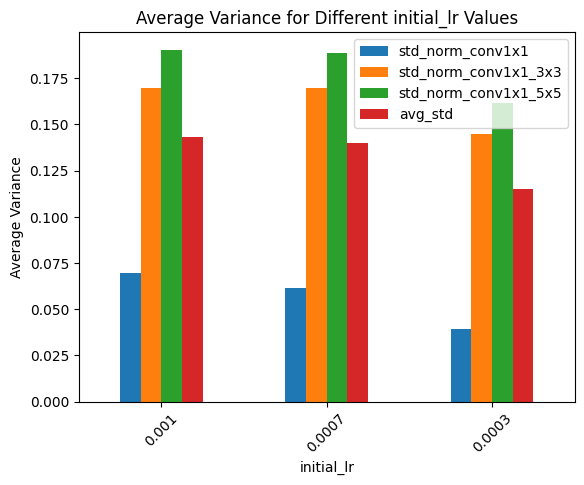

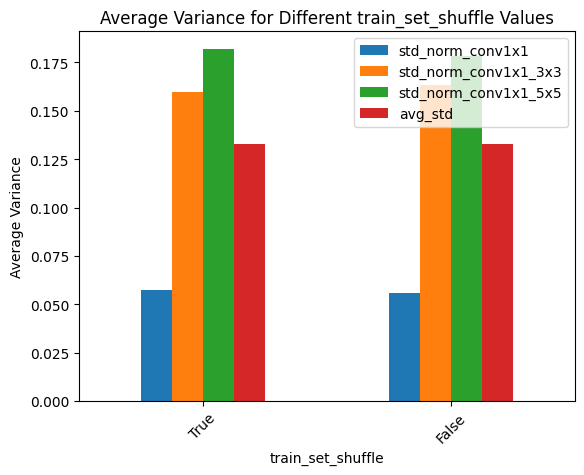

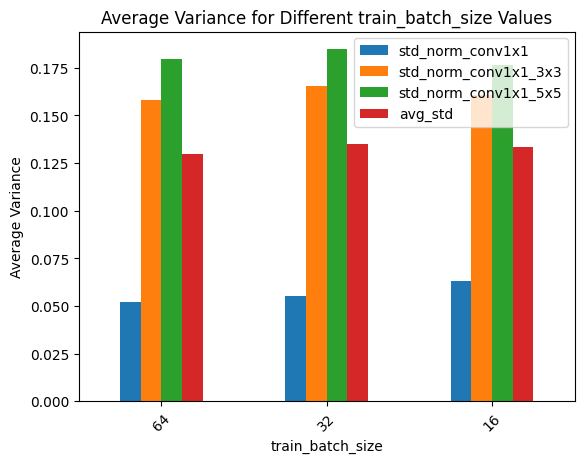

In [ ]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

# Paired T test

In [ ]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [ ]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [119]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [140]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [141]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003],
 'train_set_shuffle': [True, False],
 'train_batch_size': [64, 32, 16]}

In [148]:
def get_significant_results(df, hyperparams_choice_list):
  if not baseline:
    values_to_compare=['std_norm_conv1x1','std_norm_conv1x1_3x3','std_norm_conv1x1_5x5','avg_std']
  else:
    values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [149]:
get_significant_results(FA_SD, hyperparams_choice_list)

Values to compare: std_norm_conv1x1 variable_pair: (0.001, 0.0003) T-statistic: 7.564020143523538 One-sided P-value: 0.00032021167660999594
Values to compare: std_norm_conv1x1 variable_pair: (0.0007, 0.0003) T-statistic: 5.057830670522086 One-sided P-value: 0.0019535998696078626


Values to compare: std_norm_conv1x1_3x3 variable_pair: (0.001, 0.0003) T-statistic: 6.521846190474366 One-sided P-value: 0.000633587694747932
Values to compare: std_norm_conv1x1_3x3 variable_pair: (0.0007, 0.0003) T-statistic: 11.297369487903257 One-sided P-value: 4.749012839237076e-05


Values to compare: std_norm_conv1x1_5x5 variable_pair: (0.001, 0.0003) T-statistic: 5.9493123514776745 One-sided P-value: 0.0009587565976136449
Values to compare: std_norm_conv1x1_5x5 variable_pair: (0.0007, 0.0003) T-statistic: 10.772922101426683 One-sided P-value: 5.974828753304783e-05


Values to compare: avg_std variable_pair: (0.001, 0.0003) T-statistic: 13.012894787200844 One-sided P-value: 2.3895201328875796e-05
Values

#layer feature attribution rank frequency comparison

In [ ]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [ ]:
# Select the columns of interest
if not baseline:
  cols_of_interest = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
else:
  cols_of_interest = ['branch1', 'branch2', 'branch3']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-117-fa4b0649080b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


213    95
123    78
132    43
231    38
312    11
321     5
Name: rank_combination, dtype: int64